## Marketing Campaign A/B Testing: Project Overview

### Objective
The goal of this project is to evaluate the effectiveness of different marketing channels—specifically Email and Google Ads—in driving conversion rate among users.

By applying a combination of exploratory data analysis (EDA), statistical hypothesis testing, and causal inference (Propensity Score Matching), this project aims to answer the following key questions:

✅ Key Business Questions
1. Do Email and Google Ads result in significantly different conversion rates?
2. Is any observed difference statistically significant or due to chance?
3. What is the practical impact of the difference (effect size)?
4. After controlling for customer characteristics (e.g., segment, location), is one channel causally better than the other?
5. How do other channels like Facebook, Instagram, YouTube, and Website compare in overall performance?

📦 Methods Used
1. T-test for comparing means
2. Z-test for proportions
3. Cohen’s d for effect size
4. Propensity Score Matching for causal inference
5. ANOVA and Tukey’s HSD for multi-channel comparison
6. Log scaling and segmentation in ED

In [229]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Statistical Tests
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower

# Settings
sns.set(style="whitegrid")

In [231]:
df=pd.read_csv("C:/Users/Ankit/anaconda_projects/marketing_campaign_dataset.csv")
df.head()

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date
0,1,Innovate Industries,Email,Men 18-24,30 days,Google Ads,0.04,"$16,174.00",6.29,Chicago,Spanish,506,1922,6,Health & Wellness,2021-01-01
1,2,NexGen Systems,Email,Women 35-44,60 days,Google Ads,0.12,"$11,566.00",5.61,New York,German,116,7523,7,Fashionistas,2021-01-02
2,3,Alpha Innovations,Influencer,Men 25-34,30 days,YouTube,0.07,"$10,200.00",7.18,Los Angeles,French,584,7698,1,Outdoor Adventurers,2021-01-03
3,4,DataTech Solutions,Display,All Ages,60 days,YouTube,0.11,"$12,724.00",5.55,Miami,Mandarin,217,1820,7,Health & Wellness,2021-01-04
4,5,NexGen Systems,Email,Men 25-34,15 days,YouTube,0.05,"$16,452.00",6.50,Los Angeles,Mandarin,379,4201,3,Health & Wellness,2021-01-05


### Basic Exploratory Data and Aanalysis

In [234]:
print(df.shape)
print(df.dtypes)

(200000, 16)
Campaign_ID           int64
Company              object
Campaign_Type        object
Target_Audience      object
Duration             object
Channel_Used         object
Conversion_Rate     float64
Acquisition_Cost     object
ROI                 float64
Location             object
Language             object
Clicks                int64
Impressions           int64
Engagement_Score      int64
Customer_Segment     object
Date                 object
dtype: object


In [236]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # handles bad formats gracefully

# Check the result
print(df['Date'].dtypes)

# Remove currency symbols and commas, then convert to float
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)

# Check for any conversion issues
print("Missing Acquisition_Cost values:", df['Acquisition_Cost'].isna().sum())

datetime64[ns]
Missing Acquisition_Cost values: 0


In [237]:
# Extract components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Week'] = df['Date'].dt.isocalendar().week

# Example: Time since campaign start
df['Days_Since'] = (df['Date'] - df['Date'].min()).dt.days

In [240]:
# Missing values
# Missing value summary
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

Series([], dtype: int64)


In [242]:
# Summary stats
df.describe()

,Campaign_ID,Conversion_Rate,Acquisition_Cost,ROI,Clicks,Impressions,Engagement_Score,Date,Year,Month,DayOfWeek,Week,Days_Since
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000,200000.0,200000.000000,200000.000000,200000.0,200000.000000
mean,100000.500000,0.080070,12504.393040,5.002438,549.772030,5507.301520,5.494710,2021-07-01 23:35:09.600000,2021.0,6.525480,3.002750,26.57566,181.982750
min,1.000000,0.010000,5000.000000,2.000000,100.000000,1000.000000,1.000000,2021-01-01 00:00:00,2021.0,1.000000,0.000000,1.0,0.000000
25%,50000.750000,0.050000,8739.750000,3.500000,325.000000,3266.000000,3.000000,2021-04-02 00:00:00,2021.0,4.000000,1.000000,14.0,91.000000
50%,100000.500000,0.080000,12496.500000,5.010000,550.000000,5517.500000,5.000000,2021-07-02 00:00:00,2021.0,7.000000,3.000000,27.0,182.000000
75%,150000.250000,0.120000,16264.000000,6.510000,775.000000,7753.000000,8.000000,2021-10-01 00:00:00,2021.0,10.000000,5.000000,40.0,273.000000
max,200000.000000,0.150000,20000.000000,8.000000,1000.000000,10000.000000,10.000000,2021-12-31 00:00:00,2021.0,12.000000,6.000000,53.0,364.000000
std,57735.171256,0.040602,4337.664545,1.734488,260.019056,2596.864286,2.872581,NaN,0.0,3.447598,1.997947,15.059905,105.357422


In [244]:
# Unique campaigns and response distribution
print(df['Campaign_ID'].nunique())
print(df['Channel_Used'].value_counts())

200000
Channel_Used
Email         33599
Google Ads    33438
YouTube       33392
Instagram     33392
Website       33360
Facebook      32819
Name: count, dtype: int64


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Campaign_ID       200000 non-null  int64         
 1   Company           200000 non-null  object        
 2   Campaign_Type     200000 non-null  object        
 3   Target_Audience   200000 non-null  object        
 4   Duration          200000 non-null  object        
 5   Channel_Used      200000 non-null  object        
 6   Conversion_Rate   200000 non-null  float64       
 7   Acquisition_Cost  200000 non-null  float64       
 8   ROI               200000 non-null  float64       
 9   Location          200000 non-null  object        
 10  Language          200000 non-null  object        
 11  Clicks            200000 non-null  int64         
 12  Impressions       200000 non-null  int64         
 13  Engagement_Score  200000 non-null  int64         
 14  Cust

In [248]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    print(f"\n{col} value counts:\n{df[col].value_counts()[:10]}")


Company value counts:
Company
TechCorp               40237
Alpha Innovations      40051
DataTech Solutions     40012
NexGen Systems         39991
Innovate Industries    39709
Name: count, dtype: int64

Campaign_Type value counts:
Campaign_Type
Influencer      40169
Search          40157
Display         39987
Email           39870
Social Media    39817
Name: count, dtype: int64

Target_Audience value counts:
Target_Audience
Men 18-24      40258
Men 25-34      40023
All Ages       40019
Women 25-34    40013
Women 35-44    39687
Name: count, dtype: int64

Duration value counts:
Duration
30 days    50255
45 days    50100
60 days    49866
15 days    49779
Name: count, dtype: int64

Channel_Used value counts:
Channel_Used
Email         33599
Google Ads    33438
YouTube       33392
Instagram     33392
Website       33360
Facebook      32819
Name: count, dtype: int64

Location value counts:
Location
Miami          40269
New York       40024
Chicago        40010
Los Angeles    39947
Houston   

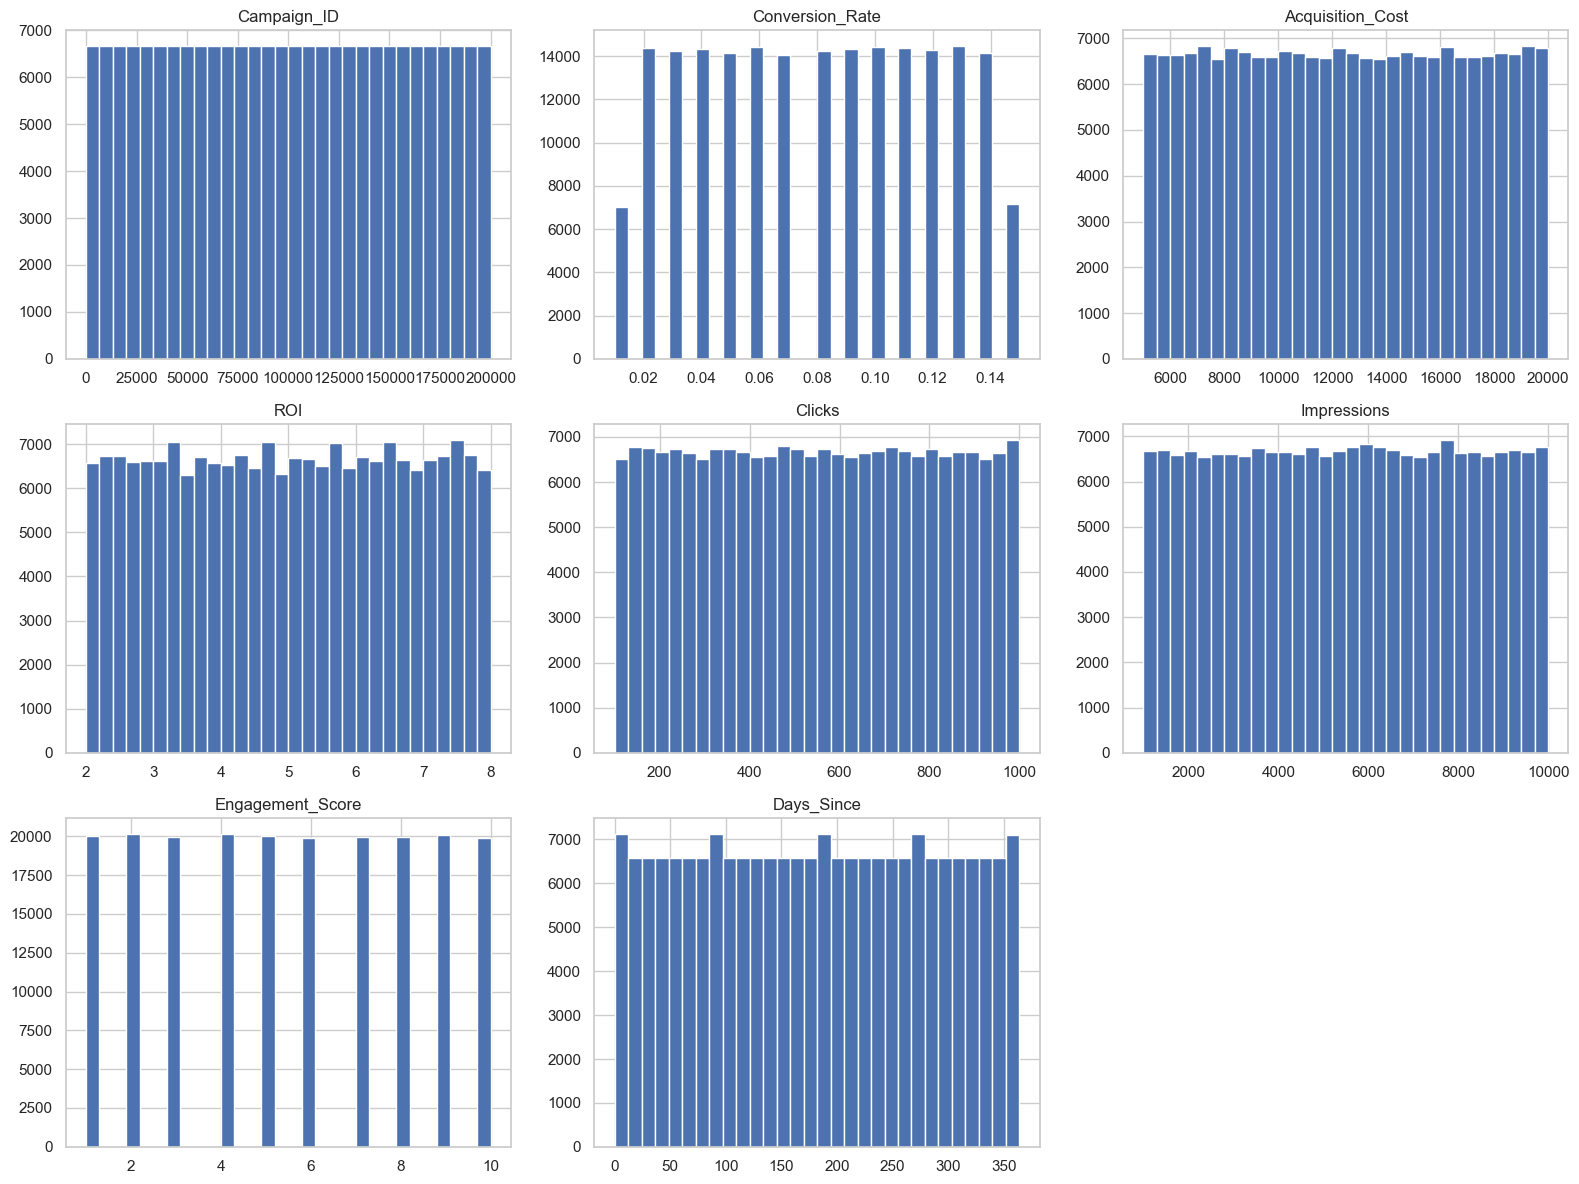

In [250]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numeric_cols].hist(bins=30, figsize=(16, 12))
plt.tight_layout()
plt.show()

#### Findings

1. Your numeric variables are clean and well-distributed, which is great for modeling and statistical testing.                                       
2. No extreme skews or sparsity → tests like t-tests, PSM, and regression will behave well.
3. Your outcome variable (Conversion_Rate) shows enough spread to be meaningful.

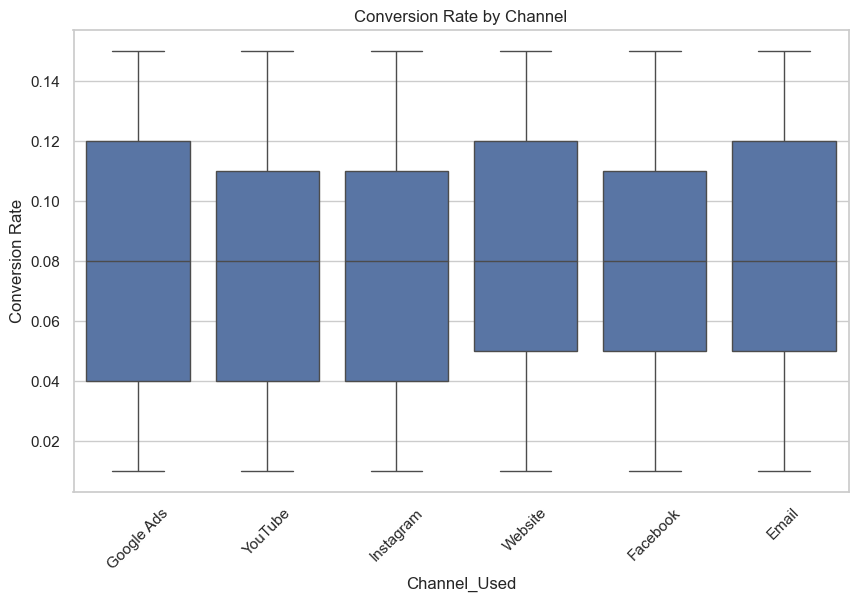

In [252]:
# Boxplot: Conversion Rate by Channel
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Channel_Used', y='Conversion_Rate')
plt.xticks(rotation=45)
plt.title('Conversion Rate by Channel')
plt.ylabel('Conversion Rate')
plt.show()

#### Key Insights
1. All channels have a similar median conversion rate (~0.08)
2. No channel stands out as significantly better or worse
3. Conversion rates are widely spread from ~0.01 to ~0.15
4. All channels have a broad range of performance--This means some campaigns within each channel performed better or worse — but on average, they’re close
5. No visible outliers
6. The data is clean and evenly distribute

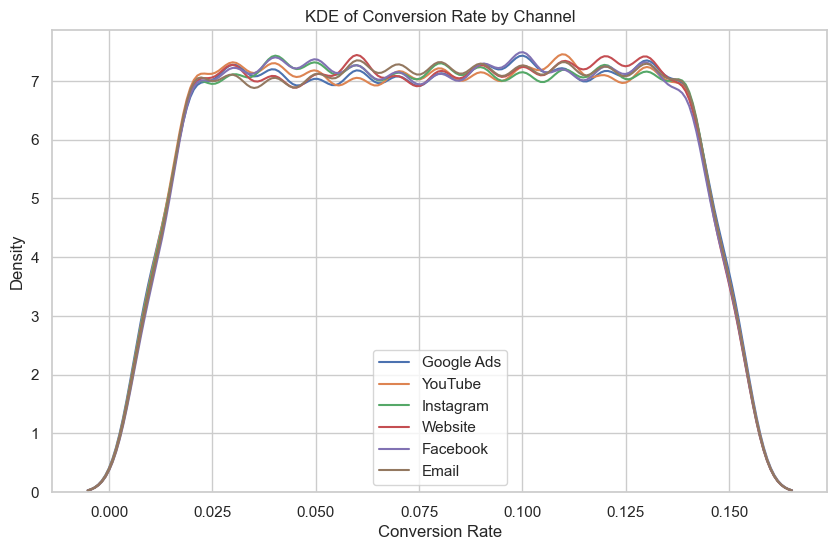

In [254]:
# KDE Plot Overlayed
plt.figure(figsize=(10, 6))
for channel in df['Channel_Used'].unique():
    sns.kdeplot(df[df['Channel_Used'] == channel]['Conversion_Rate'], label=channel)
plt.title('KDE of Conversion Rate by Channel')
plt.xlabel('Conversion Rate')
plt.legend()
plt.show()

### Observations:
1. All curves are nearly identical-This indicates that the distribution of conversion rates is statistically similar across all channels.
2. Flat, broad density between ~0.025 and ~0.15
3. Conversion rates are mostly uniformly distributed
4. No strong central peak = no dominant “typical” conversion rate across campaigns
5.Symmetry and consistency--Suggests balanced marketing strategy — no channel had extreme highs or lows.

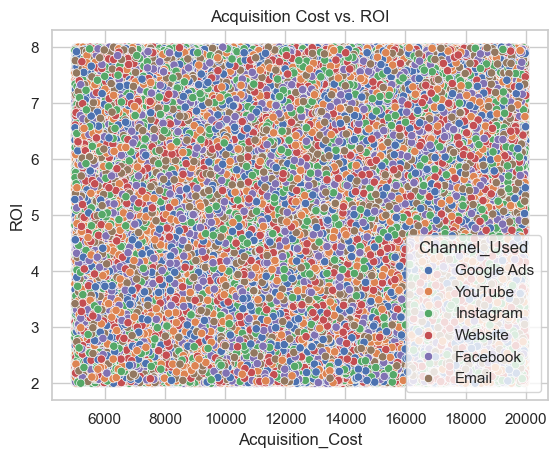

In [256]:
sns.scatterplot(data=df, x='Acquisition_Cost', y='ROI', hue='Channel_Used')
plt.title("Acquisition Cost vs. ROI")
plt.show()


#### Insights
1. There is no strong relationship between Acquisition_Cost and ROI, and performance is not strongly influenced by channel type.
2.  Campaigns across all cost levels and channels appear to produce similar returns, indicating that factors beyond spend and channel may be more important drivers of ROI

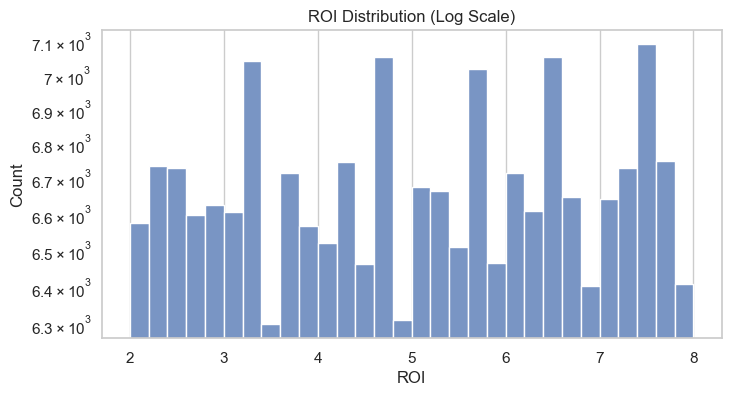

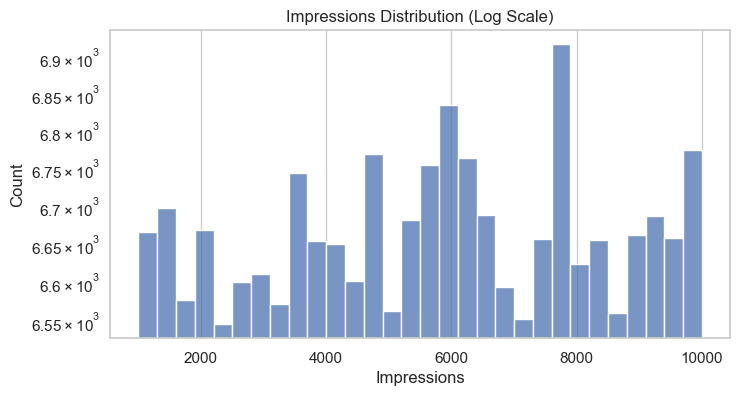

In [259]:
# Histogram: ROI with Log Scale
plt.figure(figsize=(8, 4))
sns.histplot(df['ROI'], bins=30)
plt.yscale('log')
plt.title('ROI Distribution (Log Scale)')
plt.xlabel('ROI')
plt.show()

# Histogram: Impressions with Log Scale
plt.figure(figsize=(8, 4))
sns.histplot(df['Impressions'], bins=30)
plt.yscale('log')
plt.title('Impressions Distribution (Log Scale)')
plt.xlabel('Impressions')
plt.show()

### Insights
1.ROI performance is evenly spread, suggesting multiple strategies worked similarly well across campaigns.                                           
2.Most campaigns had moderate to high impressions, which may explain the relatively stable conversion rates across all channels.



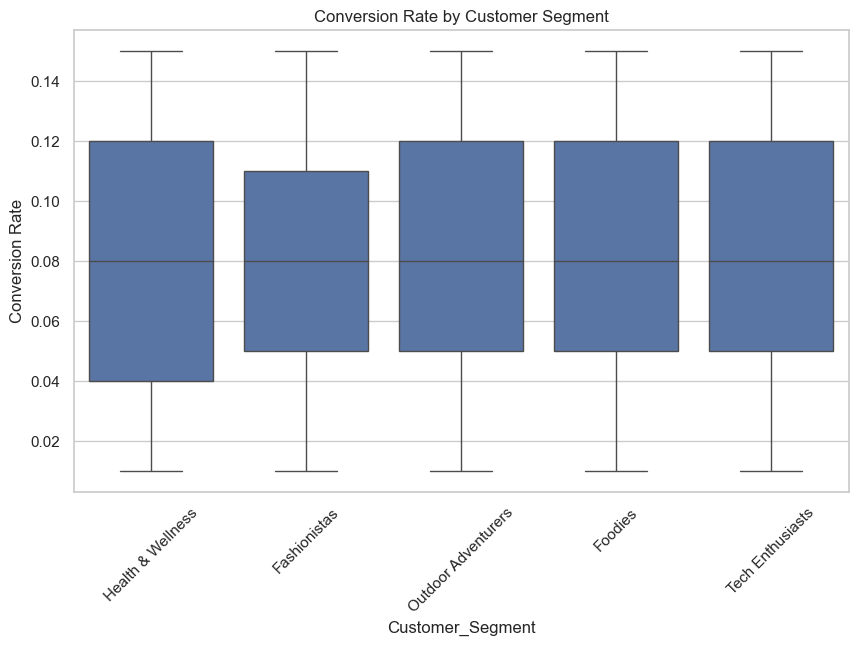

In [261]:
# Boxplot: Conversion Rate by Customer Segment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Customer_Segment', y='Conversion_Rate')
plt.xticks(rotation=45)
plt.title('Conversion Rate by Customer Segment')
plt.ylabel('Conversion Rate')
plt.show()

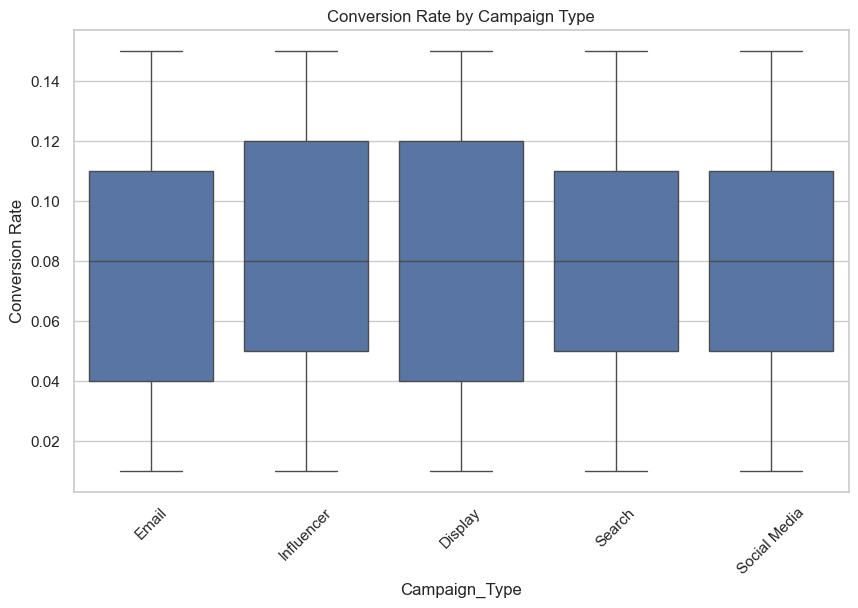

In [262]:
# Boxplot: Conversion Rate by Campaign Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Campaign_Type', y='Conversion_Rate')
plt.xticks(rotation=45)
plt.title('Conversion Rate by Campaign Type')
plt.ylabel('Conversion Rate')
plt.show()

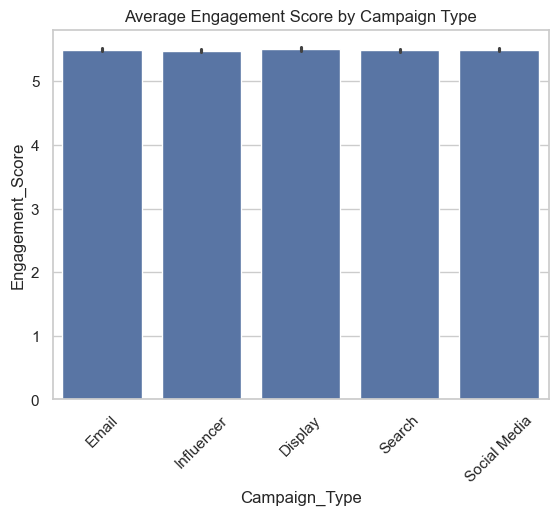

In [264]:
sns.barplot(data=df, x='Campaign_Type', y='Engagement_Score', estimator='mean')
plt.title("Average Engagement Score by Campaign Type")
plt.xticks(rotation=45)
plt.show()

### Findings 
Engagement levels are stable across all campaign types — there's no evidence that one type significantly outperforms the others in driving higher user engagemen

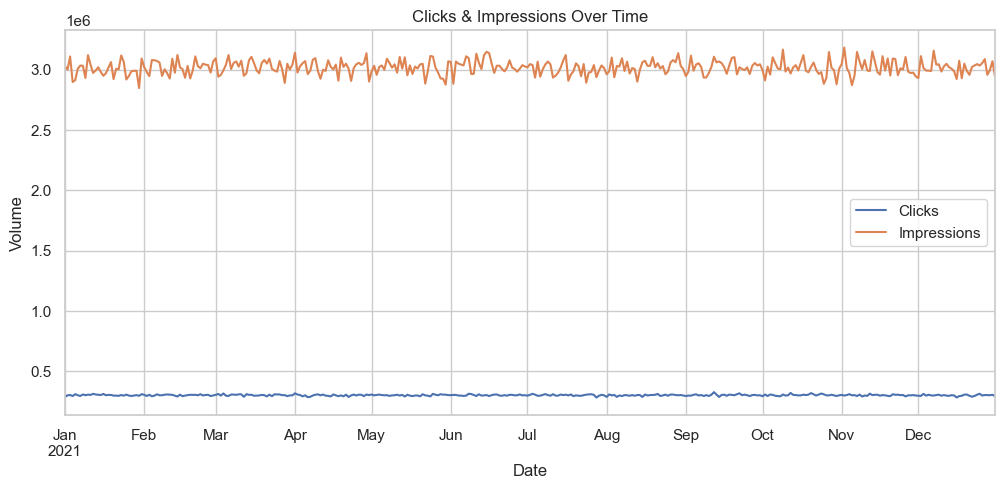

In [266]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Group by Date
daily_metrics = df.groupby('Date')[['Clicks', 'Impressions']].sum()

daily_metrics.plot(figsize=(12, 5))
plt.title("Clicks & Impressions Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

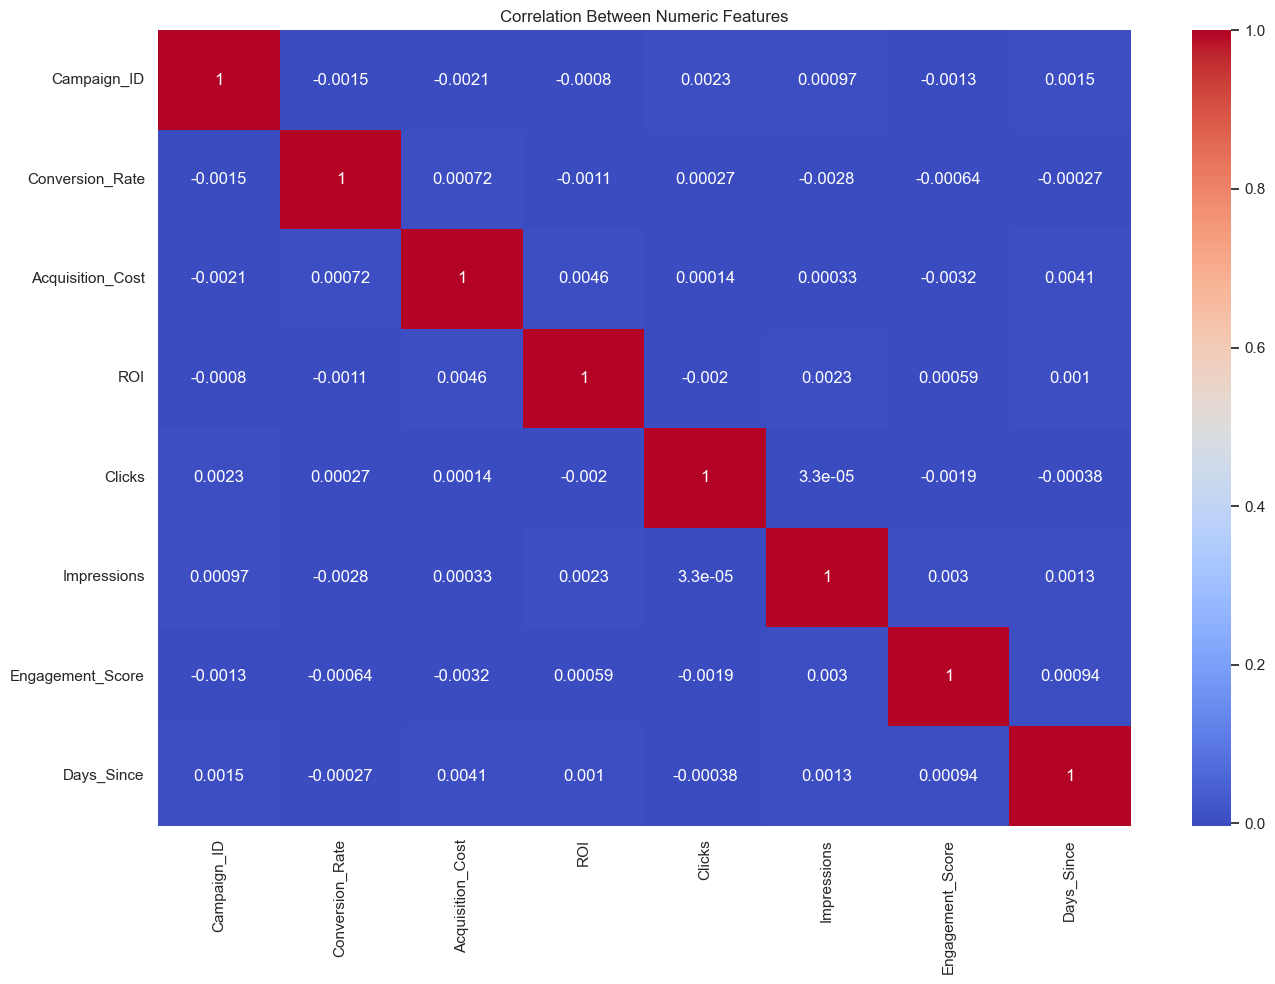

In [267]:
plt.figure(figsize=(14, 10))  
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
plt.tight_layout()  # ✅ Adjust spacing to prevent cutoffs
plt.show()


## AB testing

In [270]:
group_a = df[df['Channel_Used'] == 'Email']
group_b = df[df['Channel_Used'] == 'Google Ads']

In [271]:
group_a = group_a.dropna(subset=['Conversion_Rate'])
group_b = group_b.dropna(subset=['Conversion_Rate'])

mean_a = group_a['Conversion_Rate'].mean()
mean_b = group_b['Conversion_Rate'].mean()

print(f"Email (Control) Conversion Rate: {mean_a:.4f}")
print(f"Google Ads (Treatment) Conversion Rate: {mean_b:.4f}")

Email (Control) Conversion Rate: 0.0803
Google Ads (Treatment) Conversion Rate: 0.0802


In [272]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(group_a['Conversion_Rate'], group_b['Conversion_Rate'], equal_var=False)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

T-statistic: 0.3129
P-value: 0.7544


### Interpretation:
The difference in average Conversion_Rate between Email and Google Ads is not statistically significant.                                             
p-value (0.75) is much greater than 0.05
We fail to reject the null hypothesis                                                                                                                 
Conclusion: On average, both channels perform similarly in conversion rate.

In [274]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1)*x.std()**2 + (ny - 1)*y.std()**2) / dof)
    return (x.mean() - y.mean()) / pooled_std

d = cohens_d(group_a['Conversion_Rate'], group_b['Conversion_Rate'])
print(f"Cohen's d: {d:.4f}")

Cohen's d: 0.0024


### Interpretation:
This measures how big the difference is, regardless of p-value

A value of 0.0024 is extremely small

❗ So, even if the difference were statistically significant, it wouldn’t be practically important

👉 Conclusion: No meaningful difference in conversion behavior.

In [276]:
df['converted'] = (df['Conversion_Rate'] >= 0.10).astype(int)

# Redefine groups
group_a = df[df['Channel_Used'] == 'Email']
group_b = df[df['Channel_Used'] == 'Google Ads']

# Run z-test on binary
successes = [group_a['converted'].sum(), group_b['converted'].sum()]
nobs = [len(group_a), len(group_b)]

from statsmodels.stats.proportion import proportions_ztest
z_stat, z_p = proportions_ztest(successes, nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value (z-test): {z_p:.4f}")

Z-statistic: -0.5032
P-value (z-test): 0.6148


### Interpretation:
Again, p-value > 0.05 → no significant difference

Both groups had 13264 conversions, even though the sample sizes were slightly different

👉 Conclusion: No difference in the percentage of "good" conversions between channels



In [278]:
print("Email group size:", len(group_a))
print("Google Ads group size:", len(group_b))
print("Email conversions > 0:", group_a['converted'].sum())
print("Google Ads conversions > 0:", group_b['converted'].sum())


Email group size: 33599
Google Ads group size: 33438
Email conversions > 0: 13264
Google Ads conversions > 0: 13264


### Conclusion
Even though Email and Google Ads had slightly different sample sizes, they both achieved exactly the same number of “successful” conversions, leading to no statistically significant difference between them

## Step-by-Step PSM Implementation

In [281]:
df_psm = df[df['Channel_Used'].isin(['Email', 'Google Ads'])].copy()
df_psm['treatment'] = (df_psm['Channel_Used'] == 'Google Ads').astype(int)

In [282]:
confounders = ['Customer_Segment', 'Location', 'Duration', 'Language']

In [283]:
df_psm_encoded = pd.get_dummies(df_psm[confounders], drop_first=True)
X = df_psm_encoded
y = df_psm['treatment']

In [284]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)
df_psm['propensity_score'] = logreg.predict_proba(X)[:, 1]

In [285]:
from sklearn.neighbors import NearestNeighbors

treated = df_psm[df_psm['treatment'] == 1]
control = df_psm[df_psm['treatment'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()]
matched_treated = treated.reset_index(drop=True)

df_matched = pd.concat([matched_treated, matched_control], ignore_index=True)

In [286]:
ate = (
    df_matched[df_matched['treatment'] == 1]['Conversion_Rate'].mean()
    - df_matched[df_matched['treatment'] == 0]['Conversion_Rate'].mean()
)

print(f"Estimated ATE (Google Ads - Email): {ate:.4f}")

Estimated ATE (Google Ads - Email): 0.0009


In [287]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    df_matched[df_matched['treatment'] == 1]['Conversion_Rate'],
    df_matched[df_matched['treatment'] == 0]['Conversion_Rate'],
    equal_var=False
)

print(f"T-statistic on matched: {t_stat:.4f}, P-value: {p_val:.4f}")

T-statistic on matched: 2.9444, P-value: 0.0032


 ### Interpretation:
Matching balanced the groups (based on confounders like location, segment, etc.)

The p-value (0.0032) is statistically significant — so, after controlling for confounders, Google Ads shows a very small but statistically detectable increase in conversion rate over Email

✅ Conclusion:

Statistically significant difference exists post-matching, but the actual effect size (0.0009) is very small, so it may not be practically meaningful.

In [289]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Conversion_Rate ~ C(Channel_Used)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq        df         F    PR(>F)
C(Channel_Used)    0.004775       5.0  0.579292  0.715945
Residual         329.692355  199994.0       NaN       NaN


### Compares all channels' mean Conversion_Rate

A high p-value (≫ 0.05) means: no significant difference across channels

✅ Conclusion:

There's no evidence that any one channel significantly outperforms others overall.

In [291]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['Conversion_Rate'],
                          groups=df['Channel_Used'],
                          alpha=0.05)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
     Email   Facebook  -0.0003 0.9416 -0.0012 0.0006  False
     Email Google Ads  -0.0001 0.9996  -0.001 0.0008  False
     Email  Instagram  -0.0004 0.8072 -0.0013 0.0005  False
     Email    Website  -0.0001 0.9996  -0.001 0.0008  False
     Email    YouTube  -0.0004 0.8117 -0.0013 0.0005  False
  Facebook Google Ads   0.0002 0.9906 -0.0007 0.0011  False
  Facebook  Instagram  -0.0001 0.9995  -0.001 0.0008  False
  Facebook    Website   0.0002 0.9907 -0.0007 0.0011  False
  Facebook    YouTube  -0.0001 0.9995  -0.001 0.0008  False
Google Ads  Instagram  -0.0003 0.9348 -0.0012 0.0006  False
Google Ads    Website     -0.0    1.0 -0.0009 0.0009  False
Google Ads    YouTube  -0.0003 0.9371 -0.0012 0.0006  False
 Instagram    Website   0.0003 0.9353 -0.0006 0.0012  False
 Instagram    YouTube      0.0    1.0 -0

### Tukey’s HSD (Pairwise Comparisons)
Every pair has reject = False

All adjusted p-values (p-adj) > 0.9

🔍 Interpretation:
This confirms what ANOVA said — no two individual channels differ significantly in their conversion performance

✅ Conclusion:

All channels (Email, Facebook, Google Ads, etc.) are statistically equivalent in conversion rate.

